## ***Severstal: Steel Defect Detection***

# **Load Data**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle-2.json to kaggle-2.json


{'kaggle-2.json': b'{"username":"viktorkumpan","key":"dd161c5f7a5c58ae25680788a8ba3d9d"}'}

In [ ]:
!pip install seaborn
# Let's make sure the kaggle.json file is present.
!pip install kaggle --upgrade
!pip install --upgrade --force-reinstall --no-deps kaggle
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c severstal-steel-defect-detection

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)
     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=0b0ceaa96c72436dbd2a0cdc20adce6ecc4ca5b62a297592cae51294f0749521
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
-rw-r--r-- 1 root root 68 Jun  6 11:33 kaggle.json
 99% 1.56G/1.57G [00:16<00:00, 87.2MB/s]
100% 1.57G/1.57G [00:16<00:00, 104MB/s] 


In [ ]:
!unzip -q severstal-steel-defect-detection.zip 

# **Preprocessing data**


In [ ]:
!pip install segmentation-models-pytorch
import pandas as pd

import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

from skimage import io
from PIL import Image
import numpy as np
import cv2

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import transforms,models
import torch.optim as optim
import segmentation_models_pytorch as smp
import albumentations as albu
from albumentations.pytorch import ToTensor
import os

device = torch.device("cuda:0")
path_to_map = "/content/train.csv"
path_to_submittion = "/content/sample_submission.csv"
path_to_train = "/content/train_images"
path_to_test = "/content/test_images"

     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 245kB 13.2MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=635cc86c8841a09b0e160a751e8872cdcf640a4399870b9193ef02ea3a445e93
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=60bf59a0b4be8cc61c13f24bb0d2efbf507ab741264e4a3b6e2117bae321b9e9
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
markup_map = pd.read_csv(path_to_map)

In [ ]:
markup_map.head(2)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...


In [ ]:
def plot_class_histogram(markup_map, title=None):
  ax = sns.catplot(x='ClassId', data=markup_map, kind="count", palette="ch:.25")
  ax.fig.suptitle(title or 'Распределение классов повреждений')
  ax.fig.set_size_inches(10,5)
  plt.ylim(0, markup_map.ClassId.value_counts().max() + 100)
  plt.show()

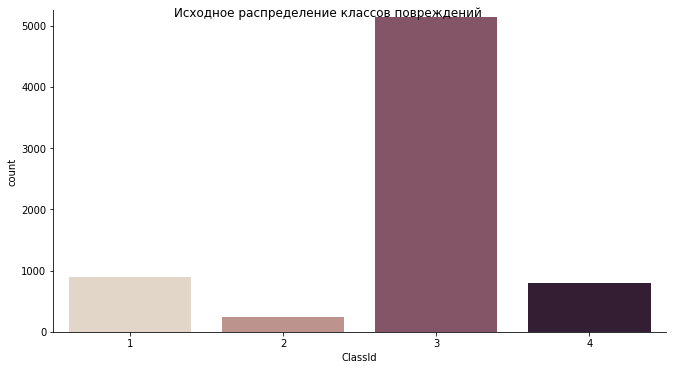

In [ ]:
plot_class_histogram(markup_map, title='Исходное распределение классов повреждений')

In [ ]:
def get_normal_map(markup_map, minimal_percent=None):
  data = {
    'ImageId':[], 
    1:[], 
    2:[], 
    3:[], 
    4:[]
  }
  
  markup_map.sort_values('ImageId')

  minimal_samples = markup_map.ClassId.value_counts().max()

  if minimal_percent:
    minimal_samples = int(markup_map.ClassId.value_counts().min() * (1 + minimal_percent))

  markup_map = markup_map.groupby('ClassId').head(minimal_samples)

  for row in markup_map.iloc:
    if data['ImageId'] and data['ImageId'][-1] == row['ImageId']:
      data[row['ClassId']].append(row['EncodedPixels'])
    else:
      data['ImageId'].append(row['ImageId'])

      for class_id in range(1, 5):
        if len(data[class_id]) != len(data['ImageId']) - 1:
          data[class_id].append(None)

      data[row['ClassId']].append(row['EncodedPixels'])
    
  for class_id in range(1, 5):
      if len(data[class_id]) != len(data['ImageId']):
        data[class_id].append(None)

  return pd.DataFrame(data)

In [ ]:
def plot_normal_map_class_histogram(normal_map, title=None):
  classId = []
  [classId.extend([class_id] * normal_map[class_id].notna().sum()) for class_id in range(1, 5)]

  plot_class_histogram(pd.DataFrame(classId, columns=['ClassId']), title=title)

In [ ]:
normal_map = get_normal_map(markup_map, minimal_percent=2.0)

In [ ]:
normal_map

,ImageId,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,None,None,None
1,0007a71bf.jpg,None,None,18661 28 18863 82 19091 110 19347 110 19603 11...,None
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,None,None,None
3,000f6bf48.jpg,None,None,None,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,None,None,229501 11 229741 33 229981 55 230221 77 230468...,None
...,...,...,...,...,...
2393,fbc97ac61.jpg,None,388659 7 388915 19 389170 32 389426 44 389682 ...,None,None
2394,fbdc2daae.jpg,None,380825 11 381065 33 381305 52 381545 69 381785...,None,None
2395,fcd374576.jpg,None,216066 11 216322 32 216578 53 216834 74 217090...,None,None
2396,fe689cf0a.jpg,None,6913 32 7169 96 7425 160 7681 224 7937 3583 11...,None,None


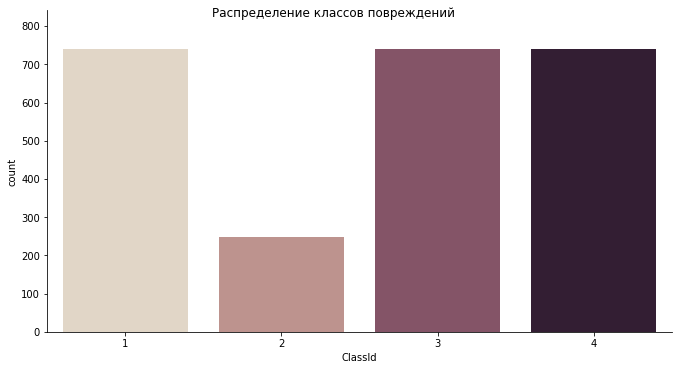

In [ ]:
plot_normal_map_class_histogram(normal_map)

In [ ]:
normal_map.head()

,ImageId,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,None,None,None
1,0007a71bf.jpg,None,None,18661 28 18863 82 19091 110 19347 110 19603 11...,None
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,None,None,None
3,000f6bf48.jpg,None,None,None,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,None,None,229501 11 229741 33 229981 55 230221 77 230468...,None


1. Надо добавить функцию разделения на тест и траин на два отдельных csv файла **pass**
2. Решить что делать с маленьким классом, скорее всего нужно будет нормализовать на него все другие классы, но потом можно попробовать GAN
3. Написать функцию визуализации данных к классу DefectsDataset +
4. Решать какую аугментацию делаем
5. Начать писать  resnet + U-net 


In [ ]:
class DefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        
    def __getclasses__(self):
        return self.labels_frame['ClassId'].unique().tolist()

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 0])
        
        image = io.imread(img_name)
        PIL_image = Image.fromarray(image)
        
        label = self.labels_frame.iloc[idx].ClassId
        label = np.array([label])
        label = torch.from_numpy(label)

        if self.transform:
            image = self.transform(PIL_image)

        # sample = {'image': torch.from_numpy(image), 'label': label}
        return image, label

In [ ]:
tfs = transforms.Compose([
    #transforms.RandomHorizontalFlip(p = 0.5),
    #transforms.RandomRotation(degrees = 60),
    #transforms.ColorJitter(saturation = 0.3, brightness=0.4),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
  ])

In [ ]:
train_data = DefectsDataset(path_to_map, path_to_train,transform = tfs)
train_loader, val_loader = prep_dataset(train_data)

test_data = DefectsDataset(path_to_submittion, path_to_test, transform=tfs)

NameError: ignored

## Сlassification Defects

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    import gc
    loss_history = []
    train_history = []
    val_history = []
    val_loss_hist = []

    for epoch in range(num_epochs):
        model.train()

        correct_samples = 0
        total_samples = 0
        loss_accum = 0
        for i_step, (x, y) in enumerate(train_loader):
              x_gpu = x.to(device)
              y_gpu = y.to(device)

              prediction = model(x_gpu)
              loss_value = loss(prediction, y_gpu.reshape((-1,)))
              _, preds = torch.max(prediction, 1)

              optimizer.zero_grad()
              loss_value.backward()
              optimizer.step()

              correct_samples += torch.sum(preds == y_gpu.reshape((-1,)))
              loss_accum += loss_value

              total_samples += y_gpu.shape[0]
              del x_gpu
              del y_gpu
              #gc.collect()
        
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = correct_samples / total_samples
        #writer.add_scalar("Loss/train", ave_loss, epoch)
        #writer.add_scalar("Acc/train", train_accuracy, epoch)

        val_accuracy, loss_val = compute_accuracy(model, val_loader, loss)
        #writer.add_scalar("Loss/valid", loss_val, epoch)
        #writer.add_scalar("Acc/valid", val_accuracy, epoch)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        val_loss_hist.append(loss_val)

        print("Average loss: %f, Val loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss,loss_val, train_accuracy, val_accuracy))
        
        #print('Epoch:', epoch, 'LR:', scheduler.get_last_lr())

    return loss_history, train_history, val_history, val_loss_hist, model

def compute_accuracy(model, loader,loss):
    # добавить на трейне !!!
    # проверить на пустой модели
    model.eval()
    
    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        loss_accum = 0
        
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu.reshape((-1,)))
            _, preds = torch.max(prediction, 1)

            correct_samples += torch.sum(preds == y_gpu.reshape((-1,)))
            total_samples += y_gpu.shape[0]
            loss_accum += loss_value

            del x_gpu
            del y_gpu
            #gc.collect()

        loss_val = loss_accum / (i_step + 1)
        val_accuracy = correct_samples / total_samples

        return val_accuracy, loss_val

In [ ]:
net = models.resnet18()
net.to(device)
net.fc.out_features = 4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001) #optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

loss_history, train_history, val_history, val_loss_hist, net = train_model(net, train_loader, val_loader, criterion, optimizer, 3)

NameError: ignored

## Segmentation

In [ ]:
normal_map.iloc[225][1:]

1    19213 3 19469 9 19725 14 19981 20 20237 23 204...
2                                                 None
3    163335 10 163591 30 163847 40 164103 40 164359...
4                                                 None
Name: 225, dtype: object

19213 3 19469 9 19725 14 19981 20 20237 23 20493 23 20749 23 21005 23 21261 23 21517 23 21773 23 22029 23 22285 23 22541 23 22797 24 23053 24 23309 24 23565 24 23821 24 24077 24 24333 24 24589 24 24845 24 25101 22 25357 18 25613 14 25869 10 26125 6 26381 2 74972 9 75228 26 75484 35 75740 35 75996 35 76151 3 76252 35 76402 8 76509 34 76653 13 76765 35 76904 18 77021 35 77156 22 77277 35 77407 27 77533 35 77658 32 77789 35 77911 35 78045 35 78167 34 78301 35 78423 34 78557 35 78679 34 78813 36 78935 34 79069 36 79192 33 79325 36 79448 33 79582 35 79704 33 79838 35 79960 33 80094 35 80216 33 80350 35 80472 33 80606 35 80728 33 80862 35 80984 33 81127 26 81240 33 81400 9 81496 33 81669 13 81753 32 81925 25 82009 32 82181 25 82265 31 82437 26 82521 31 82694 25 82777 31 82950 25 83033 31 83084 2 83206 25 83289 31 83340 6 83462 25 83545 31 83595 11 83718 24 83801 31 83851 14 83974 24 84057 31 84107 18 84230 24 84304 2 84314 27 84362 23 84486 24 84558 4 84570 21 84618 25 84743 23 84811 7 84826

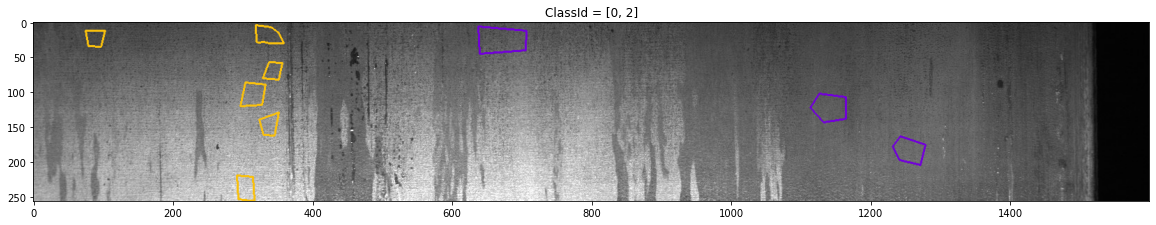

In [ ]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]


def get_image_mask(idx):
  masks = np.zeros((256, 1600, 4), dtype=np.uint8)
  labels = normal_map.iloc[idx][1:]
  for i, label in enumerate(labels):
    if not pd.isnull(label):
      print(label)
      label = label.split(" ")

      positions = map(int, label[0::2])
      length = map(int, label[1::2])
      mask = np.zeros(256 * 1600, dtype=np.uint8)
      for pos, le in zip(positions, length):
          mask[pos - 1:pos + le - 1] = 1

      masks[:, :, i] = mask.reshape(256, 1600, order='F')
  return masks.transpose(2, 0, 1) #4,256,1600


def show_image_mask(idx,image = None ,mask = None):
  img = cv2.imread(str(path_to_train + '/' + markup_map.ImageId[idx])) if image == None else image.numpy()
  labels = list()

  masks = get_image_mask(idx) if mask == None else mask.numpy()

  for ch in range(4):
    if masks[ch].max() != 0:
      labels.append(ch)

      print(ch,masks[ch].max())
      contours, _ = cv2.findContours(np.uint8(masks[ch]), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

      for i in range(0, len(contours)):
        cv2.polylines(img, contours[i], True, palet[ch], 2)

  plt.figure(figsize=(20, 5))
  plt.title('ClassId = %s' % labels)
  plt.imshow(img)
  plt.show()

show_image_mask(225)#225

In [ ]:

class DefectsSegmentationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, subset="train"):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = csv_file
        self.root_dir = root_dir
        self.transform = transform
        self.subset = subset
        
    def __getclasses__(self):
        return self.labels_frame['ClassId'].unique().tolist()

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 0])
        
        image = cv2.imread(img_name)
        #image = cv2.cvtColor(image, cv2.G)


        if self.subset == "train" or self.subset == "valid":
          mask = make_mask(idx, self.labels_frame)
          augment = self.transform(image=image, mask=mask)

          mask = augment["mask"][0].permute(2, 0, 1)
          image = augment["image"]

          return image, mask 

        else:
          augment = self.transform(image=image)
          image = augment['image']

          return image, self.labels_frame.iloc[idx, 0]
        
def make_mask(row_id, df):
    """Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`"""
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][1:]
    masks = np.zeros((256, 1600, 4), dtype=np.float32)

    for idx, label in enumerate(labels.values):
      if not pd.isnull(label) :
        label = label.split(" ")

        positions = map(int, label[0::2])
        length = map(int, label[1::2])

        mask = np.zeros(256 * 1600, dtype=np.uint8)

        for pos, le in zip(positions, length):
          mask[pos:(pos + le)] = 1

        masks[:, :, idx] = mask.reshape(256, 1600, order='F')

    return masks

In [ ]:
def prep_dataset(data_train, count_val = 5, batch_size = 8,):
  data_size = len(data_train)

  validation_split = 0.2
  split = int(np.floor(validation_split * data_size))
  indices = list(range(data_size))
  np.random.shuffle(indices)
  train_indices,val_indices = indices[split:],indices[:split]

  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)

  train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                                   sampler=train_sampler)
    
  val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                                 sampler=val_sampler)

  return train_loader, val_loader

In [ ]:
tfs = albu.Compose([
    #albu.HorizontalFlip(p = 0.5),
    #transforms.RandomRotation(degrees = 60),
    #transforms.ColorJitter(saturation = 0.3, brightness=0.4),
    #albu.CenterCrop(224),
    albu.Resize(height=256, width=256),
    albu.RandomBrightnessContrast(0.3),
    albu.HorizontalFlip(p = 0.5),
    albu.VerticalFlip(p = 0.5),
    albu.Blur(blur_limit=1, p=0.5),
    albu.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ToTensor(),
    
  ])

In [ ]:
train_data = DefectsSegmentationDataset(normal_map, path_to_train, transform=tfs)
train_loader, val_loader = prep_dataset(train_data)

In [ ]:
img = train_data[5]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 1.0
3 1.0


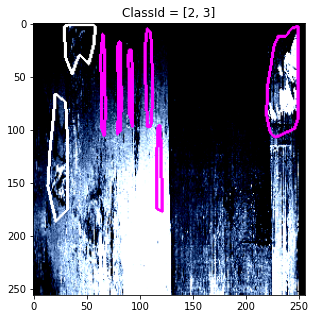

In [ ]:
show_image_mask(225, image = img[0].permute(1, 2, 0), mask = img[1])

In [ ]:
train_data[0][1].shape

torch.Size([4, 256, 256])

In [ ]:
### Модель которая тренилась

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda:0'
EPOCHES_NUM = 30

# create segmentation model with pretrained encoder

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)

model = model.to(device)

loss = smp.utils.losses.DiceLoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4, weight_decay = 1e-05),
])

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, verbose=True)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [ ]:
train_metrics_logs = []
valid_metrics_logs = []

In [ ]:
max_score = 0
 
for epoch in range(EPOCHES_NUM):
    
    print(f'\nEpoch: {epoch + 1}')
 
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
 
    train_metrics_logs.append(train_logs)
    valid_metrics_logs.append(valid_logs)
    
    scheduler.step(valid_logs['dice_loss'])
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './model.pth')
        print('Model saved!')


Epoch: 1
valid: 100%|██████████| 60/60 [00:08<00:00,  6.98it/s, dice_loss - 0.9077, iou_score - 0.1061]
Model saved!

Epoch: 2
valid: 100%|██████████| 60/60 [00:08<00:00,  6.91it/s, dice_loss - 0.7575, iou_score - 0.2231]
Model saved!

Epoch: 3
valid: 100%|██████████| 60/60 [00:08<00:00,  6.98it/s, dice_loss - 0.562, iou_score - 0.3414]
Model saved!

Epoch: 4
valid: 100%|██████████| 60/60 [00:08<00:00,  7.04it/s, dice_loss - 0.5286, iou_score - 0.3382]

Epoch: 5
valid: 100%|██████████| 60/60 [00:08<00:00,  6.93it/s, dice_loss - 0.5981, iou_score - 0.2672]

Epoch: 6
valid: 100%|██████████| 60/60 [00:08<00:00,  6.96it/s, dice_loss - 0.4864, iou_score - 0.3639]
Model saved!

Epoch: 7
valid: 100%|██████████| 60/60 [00:08<00:00,  6.86it/s, dice_loss - 0.4997, iou_score - 0.3592]

Epoch: 8
valid: 100%|██████████| 60/60 [00:08<00:00,  6.82it/s, dice_loss - 0.464, iou_score - 0.3892]
Model saved!

Epoch: 9
valid: 100%|██████████| 60/60 [00:08<00:00,  6.96it/s, dice_loss - 0.4828, iou_score - 

In [ ]:

def plot_logs(train_logs, valid_logs, name):
  train_logs_history = [log[name] for log in train_logs]
  valid_logs_history = [log[name] for log in valid_logs]
  x = range(len(train_logs_history))
 
  plt.figure()
  plt.plot(x, train_logs_history, label=f'train {name}')
  plt.plot(x, valid_logs_history, label=f'valid {name}')
 
  plt.legend()
  plt.show()

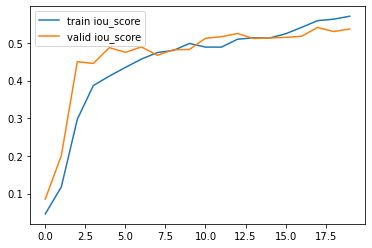

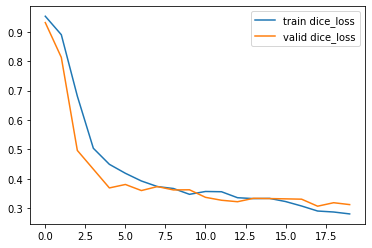

In [ ]:
plot_logs(train_metrics_logs, valid_metrics_logs, 'iou_score')
plot_logs(train_metrics_logs, valid_metrics_logs, 'dice_loss')

In [ ]:
# Submition

In [ ]:
test_tfs = albu.Compose([
    #albu.HorizontalFlip(p = 0.5),
    #transforms.RandomRotation(degrees = 60),
    #transforms.ColorJitter(saturation = 0.3, brightness=0.4),
    #albu.CenterCrop(224),
    #albu.Resize(width=512, height=256),
    #albu.RandomBrightnessContrast(0.2)
    albu.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ToTensor(),
  ])

In [ ]:
train_data = DefectsSegmentationDataset(normal_map, path_to_train, transform=test_tfs)
train_loader, val_loader = prep_dataset(train_data)

In [ ]:
batch_size = 8

df_submit = pd.read_csv(path_to_submittion)
test_data = DefectsSegmentationDataset(df_submit.copy(), path_to_test, subset="test", transform=test_tfs)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
def run_length_encode(mask):
    m = mask.T.flatten()
    if m.sum()==0:
        rle=''
    else:
        m   = np.concatenate([[0], m, [0]])
        run = np.where(m[1:] != m[:-1])[0] + 1
        run[1::2] -= run[::2]
        rle = ' '.join(str(r) for r in run)
    return rle

In [ ]:
def get_normal_pred_mask(mask, class_id):
  m = mask[class_id]

  m = torch.from_numpy(np.where(m > threshold_mask_pixel[class_id], 1, m))
  m = torch.from_numpy(np.where(m <= threshold_mask_pixel[class_id], 0, m))
  return m.numpy()

In [ ]:
threshold_mask_pixel = [ 0.45, 0.45, 0.40, 0.40,] 

Сравнение предсказанного:

In [ ]:
imgs[0].permute(1,2,0).shape

torch.Size([256, 1600, 3])

In [ ]:
for imgs, masks in train_data:
  imgs = torch.tensor([imgs.numpy()]).to(device)
  #masks.to(device)
  break

pred_mask = model.predict(imgs).to('cpu')
#norm_pred_mask = torch.tensor([get_normal_pred_mask(pred_mask[i],i) for i in range(4)])

show_image_mask(255, image=imgs[0].permute(1,2,0), mask=pred_mask[0])

TypeError: ignored

In [ ]:
imgs_names = []
encoded_pixels = []

# from kaggle https://www.kaggle.com/hengck23/efficientb5-mish-256x400crop-05
threshold_mask_pixel = [ 0.45, 0.45, 0.40, 0.40,] 

for imgs, img_names in test_loader:
  imgs = imgs.to(device)
  
  masks = model.predict(imgs).to('cpu')

  for batch_num in range(len(imgs)):
    img_name = img_names[batch_num]
    mask = masks[batch_num]

    for class_id in range(4):
      imgs_names.append(img_name+'_'+str(class_id+1))

      m = get_normal_pred_mask(mask, class_id)
      
      encoded_pixels.append(run_length_encode(m))

In [ ]:
sb = pd.DataFrame({
    'ImageId_ClassId': imgs_names,
    'EncodedPixels': encoded_pixels
})

sb.to_csv('sample_submission.csv')